In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [3]:
# 예측할 종목은 한양증권(001750) 입니다
# 기간은 00-01-04 ~ 21-02-05 입니다
# Yahoo Finanace에서 다운로드 받아 null값을 제거한 데이터를 사용합니다

df = pd.read_csv('C:\Jupyter_Project\Hanyang_Securities_F.csv')
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6300,7100,6300,7000,1619.266357,56800
1,2000-01-05,6700,7100,6610,6700,1549.868774,52100
2,2000-01-06,7000,7000,6250,6300,1457.339844,64900
3,2000-01-07,6350,6600,6300,6370,1473.532349,61800
4,2000-01-10,6610,6700,6300,6500,1503.603882,56100


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5181,2021-02-01,9200,9480,9100,9380,9380.0,81355
5182,2021-02-02,9460,9810,9460,9700,9700.0,105755
5183,2021-02-03,9850,10200,9800,9990,9990.0,170966
5184,2021-02-04,10100,10200,9940,10150,10150.0,133504
5185,2021-02-05,10200,10800,10150,10650,10650.0,247224


In [5]:
# OHLC를 Adj OHLC로 바꾸기 위한 비율입니다
# Adj OHLC는 과거의 절대가격을 현재 가격의 시점으로 보기위한 수정된 가격입니다
# 과거 발생한 액면분할과 현금배당을 반영한 Adj Close를 기준으로 조정합니다

ratio = df['Adj Close']/df['Close']
ratio

0       0.231324
1       0.231324
2       0.231324
3       0.231324
4       0.231324
          ...   
5181    1.000000
5182    1.000000
5183    1.000000
5184    1.000000
5185    1.000000
Length: 5186, dtype: float64

In [6]:
df['Adj Open'] = df['Open']*ratio
df['Adj High'] = df['High']*ratio
df['Adj Low'] = df['Low']*ratio

In [7]:
df.drop(['Open','High','Low','Close'], axis=1, inplace=True)

In [8]:
df.rename(columns={'Adj Open':'Open', 'Adj High':'High', 'Adj Low':'Low', 'Adj Close':'Close'}, inplace=True)

In [9]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

df

,Open,High,Low,Close,Volume
0,1457.339721,1642.398734,1457.339721,1619.266357,56800
1,1549.868774,1642.398253,1529.049641,1549.868774,52100
2,1619.266493,1619.266493,1445.773655,1457.339844,64900
3,1468.905874,1526.736814,1457.339686,1473.532349,61800
4,1529.049486,1549.868617,1457.339147,1503.603882,56100
...,...,...,...,...,...
5181,9200.000000,9480.000000,9100.000000,9380.000000,81355
5182,9460.000000,9810.000000,9460.000000,9700.000000,105755
5183,9850.000000,10200.000000,9800.000000,9990.000000,170966
5184,10100.000000,10200.000000,9940.000000,10150.000000,133504


In [10]:
# MinMaxScaler 클래스를 사용하여 데이터를 스케일링 합니다.
# MinMaxScaler는 데이터의 최대값이 1, 최소값이 0이 되도록 변환합니다

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df[scale_cols])

# 정규화가 완료된 데이터들은 pandas dataframe으로 변환합니다
# pandas는 시계열 자료에 대한 다양한 기능을 제공하여 LSTM에서 사용하는 window를 만들때 유용합니다

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

          Open      High       Low     Close    Volume
0     0.069093  0.078420  0.072692  0.082280  0.020301
1     0.076891  0.078420  0.078924  0.076473  0.018620
2     0.082740  0.076587  0.071686  0.068730  0.023197
3     0.070068  0.069256  0.072692  0.070085  0.022088
4     0.075136  0.071089  0.072692  0.072601  0.020050
...        ...       ...       ...       ...       ...
5181  0.721622  0.699387  0.736878  0.731697  0.029080
5182  0.743534  0.725532  0.768164  0.758474  0.037804
5183  0.776402  0.756432  0.797711  0.782742  0.061119
5184  0.797472  0.756432  0.809878  0.796130  0.047725
5185  0.805899  0.803969  0.828128  0.837970  0.088383

[5186 rows x 5 columns]


In [11]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

data = df_scaled[feature_cols]
target = df_scaled[label_cols]

data.shape, target.shape

((5186, 4), (5186, 1))

In [12]:
from sklearn.model_selection import train_test_split

x_training, x_test, y_training, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.2)

# train/validation split (gives us train and validation sets)
x_train, x_validation, y_train, y_validation = train_test_split(x_training,
                                                                y_training,
                                                                test_size=0.25)

# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(target),2),
                                                       round(len(y_validation)/len(target),2),
                                                       round(len(y_test)/len(target),2)))

train: 0.6% | validation: 0.2% | test 0.2%


In [13]:
x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape

((3111, 4), (3111, 1), (1037, 4), (1037, 1), (1038, 4), (1038, 1))

In [14]:
# 정해진 window_size에 기반하여 20일 기간의 데이터 셋을 묶어준다

def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [15]:
x_train, y_train = make_dataset(x_train, y_train, 20)
x_validation, y_validation = make_dataset(x_validation, y_validation, 20)
x_test, y_test = make_dataset(x_test, y_test, 20)

x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape

((3091, 20, 4), (3091, 1), (1017, 20, 4), (1017, 1), (1018, 20, 4), (1018, 1))

>> 메모리셀을 변화시켜 과적합 여부를 관찰할 수 있을 것이다

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

# LSTM은 RNN 알고리즘의 특별한 한 종류입니다. 
# LSTM은 긴 의존기간을 필요로 하는 데이터를 학습하는데 효과적인 모델입니다
# 이 모델은 add함수를 사용하여 레이어들을 선형으로 쌓는 Sequential Model 입니다
# 16 메모리 셀을 가진 LSTM 레이어 하나와 Dense 레이어 하나(output)을 사용합니다
# input_shape는 input이 어떤 모양으로 들어올지에 대한 정보입니다. 데이터 개수는 중요하지 않기에 window_size와 feature만 알려주면 된다
# train_feature.shape[1] = window_size / train_feature.shape[2] = ['Open', 'High', 'Low', 'Volume']
# 예측하고자 하는 target 개수가 하나이므로 Dense(1)dl 출력으로 사용됩니다



model = Sequential()
model.add(LSTM(20, 
               input_shape=(x_test.shape[1], x_test.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                2000      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 2,021
Trainable params: 2,021
Non-trainable params: 0
_________________________________________________________________


In [18]:
# val_loss가 10회 같을 시 early_stop, batch_size(=K)는 K문제 풀고 답보고 하는 식
# 위에서 모델을 구성한 후 compile 메서드를 호출하여 학습과정을 설정합니다
# optimizer : 훈련 과정을 설정한다
# loss : 최적화 과정에서 최소화될 손실 함수(loss function)을 설정합니다
# metrics : 훈련을 모니터링하기 위해 사용됩니다
# validation_data = 검증 데이터를 사용합니다. 각 에포크마다 정확도도 함께 출력됩니다
# 이 정확도는 훈련이 잘 되고 있는지를 보여줄 뿐이며 실제로 모델이 검증데이터를 학습하지는 않습니다
# 검증 데이터의 loss가 낮아지다가 높아지기 시작하면 overfitting의 신호입니다
# verbose / 0 : 출력 없음 / 1 : 훈련 진행도 보여주는 진행 막대 보여줌 / 2 : 미니 배치마다 손실 정보 출력

from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))
    
    
model.compile(loss = RMSE, optimizer='adam', metrics=[soft_acc])

early_stop = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=128,
                    validation_data=(x_validation, y_validation), 
                    callbacks=[early_stop, checkpoint])


score_train = model.evaluate(x_train, y_train, batch_size=128)
score_validation = model.evaluate(x_validation, y_validation, batch_size=128)
score_test = model.evaluate(x_test, y_test, batch_size=128)


print('train loss, train acc : ' + str(score_train))
print('validation loss, validation acc : ' + str(score_validation))
print('test loss, test acc : ' + str(score_test))

Epoch 1/200
25/25 [==============================] - 3s 74ms/step - loss: 0.4539 - soft_acc: 0.7559 - val_loss: 0.3214 - val_soft_acc: 0.7460

Epoch 00001: val_loss improved from inf to 0.32141, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 2/200
25/25 [==============================] - 0s 9ms/step - loss: 0.2746 - soft_acc: 0.7490 - val_loss: 0.2244 - val_soft_acc: 0.7450

Epoch 00002: val_loss improved from 0.32141 to 0.22439, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 3/200
25/25 [==============================] - 0s 8ms/step - loss: 0.2159 - soft_acc: 0.7515 - val_loss: 0.2212 - val_soft_acc: 0.7460

Epoch 00003: val_loss improved from 0.22439 to 0.22121, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 4/200
25/25 [==============================] - 0s 8ms/step - loss: 0.2138 - soft_acc: 0.7415 - va

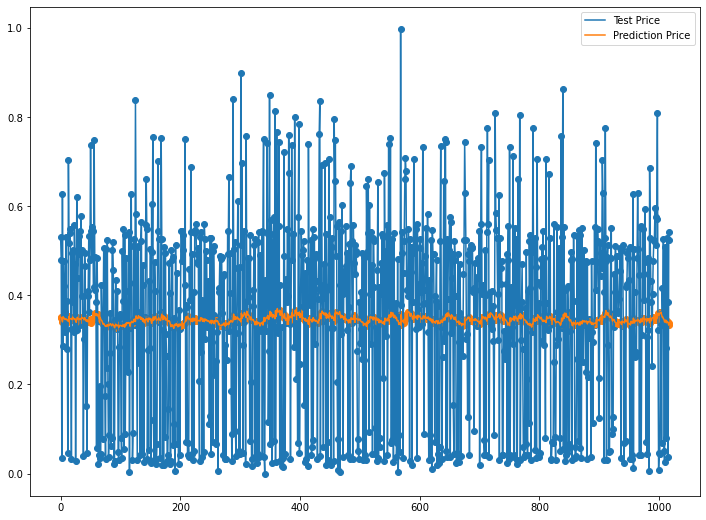

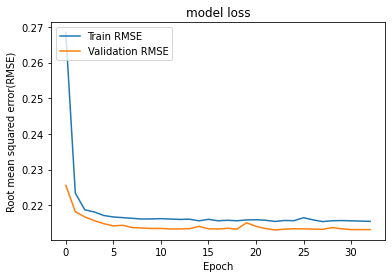

In [66]:
prediction = model.predict(x_test)

plt.figure(figsize=(12,9))
plt.plot(np.asarray(y_test), label='Test Price')
plt.plot(prediction, label='Prediction Price')
x_values = list(range(1018))
plt.scatter(x_values, np.asarray(y_test))
plt.scatter(x_values, prediction)
plt.legend()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Root mean squared error(RMSE)')
plt.xlabel('Epoch')
plt.legend(['Train RMSE', 'Validation RMSE'], loc='upper left')
plt.show()